# Localizing Microscopic Particles

This notebook provides you with a complete code example that trains a convolutional neural network with a dense top using annotated and simulated data and then applies it to experimental videos of an optically trapped particle.

## Loading the Videos

Download the `particle_dataset`. This folder contains two videos with an optically trapped particle. One video is acquired with very low noise (`low_noise.avi`), while the other with very high noise (`high_noise.avi`).

In [1]:
import os

if not os.path.exists("particle_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/particle_dataset")

Cloning into 'particle_dataset'...


Load these videos ... 

In [2]:
import cv2
import numpy as np

def load_video(path, frames_to_load, image_size):
    """Load video."""
    video = cv2.VideoCapture(path)
    
    data = []
    for _ in range(frames_to_load):
        (_, frame) = video.read()
        frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255
        frame = cv2.resize(frame, (image_size, image_size))
        data.append(frame)
    
    return np.array(data)

In [3]:
image_size = 51
video_low_noise = load_video(os.path.join("particle_dataset", "high_noise.avi"),
                             frames_to_load=100, image_size=image_size)
video_high_noise = load_video(os.path.join("particle_dataset", "low_noise.avi"),
                              frames_to_load=100, image_size=image_size)


... and plot some of the frames.

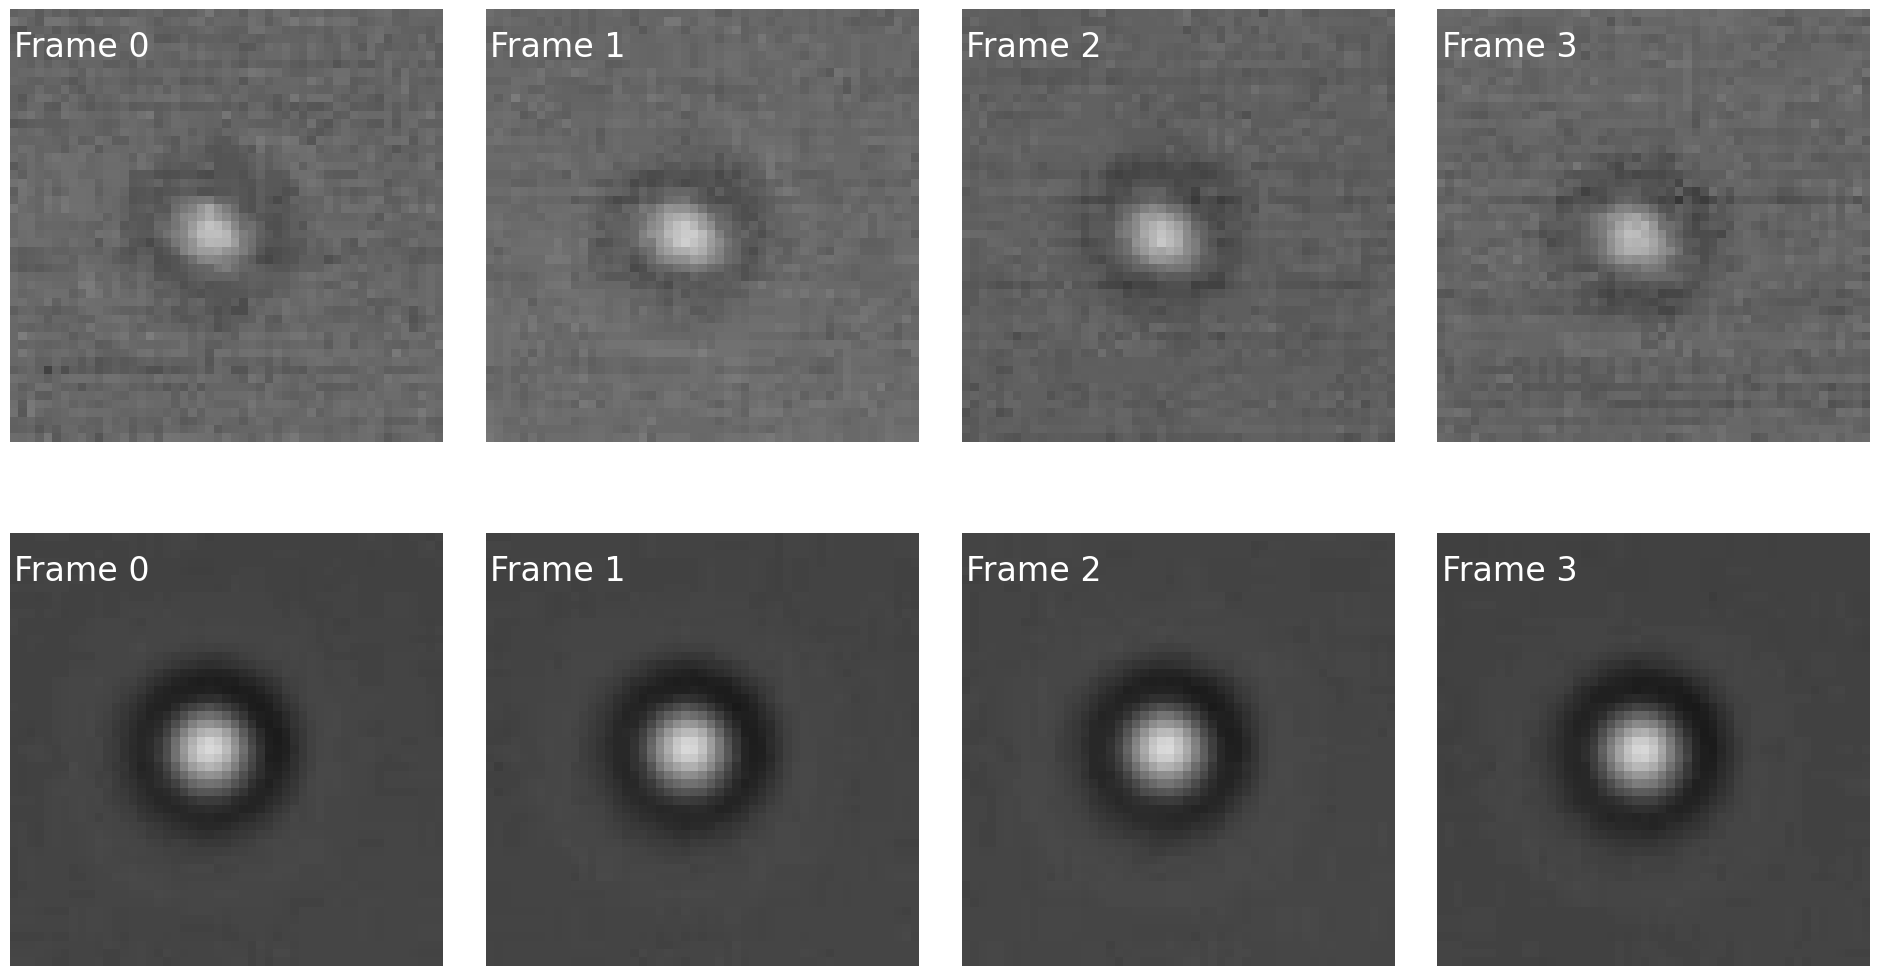

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 4, figsize=(24, 13))
for i in range(4):
    axs[0, i].imshow(video_low_noise[i], cmap="gray", vmin=0, vmax=1)
    axs[0, i].text(0, 5, f"Frame {i}", color="white", fontsize=24)
    axs[0, i].axis("off")
    
    axs[1, i].imshow(video_high_noise[i], cmap="gray", vmin=0, vmax=1)
    axs[1, i].text(0, 5, f"Frame {i}", color="white", fontsize=24)
    axs[1, i].axis("off")
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


## Manually Annotating the Videos

Define a class to be able to interactively select the centroid of particles in some of the video frames ...

In [5]:
from matplotlib.widgets import Cursor

class ManualAnnotation:
    """Graphical interface for manual annotation."""

    def __init__(self, images):
        """Initialize manual annotation."""
        self.images = images
        self.positions = []
        self.i = 0
        self.fig, self.ax = plt.subplots(1, 1, figsize=(5, 5))
        self.fig.canvas.header_visible = False
        self.fig.canvas.footer_visible = False

    def start(self):
        """Start manual annotation."""
        self.im = self.ax.imshow(self.images[self.i], cmap="gray", 
                                 vmin=0, vmax=1)
        self.text = self.ax.text(3, 5, 
                                 f"Frame {self.i + 1} of {len(self.images)}", 
                                 color="white", fontsize=12)
        self.ax.axis("off")
        self.cursor = Cursor(self.ax, useblit=True, color="red", linewidth=1)
        self.cid = self.fig.canvas.mpl_connect("button_press_event", 
                                               self.onclick)
        self.next_image()
        plt.show()

    def next_image(self):
        """Get next image."""
        self.im.set_data(self.images[self.i])
        self.text.set_text(f"Frame {self.i + 1} of {len(self.images)}")
        self.fig.canvas.draw_idle()

    def onclick(self, event):
        """Save position on click."""
        self.positions.append([event.xdata, event.ydata])
        if self.i < len(self.images) - 1:
            self.i += 1
            self.next_image()
        else:
            self.fig.canvas.mpl_disconnect(self.cid)
            plt.close()
            return

... use it to annotate a subset of images ...

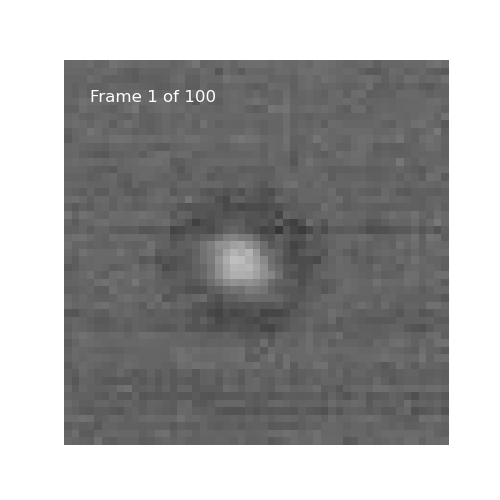

In [6]:
%matplotlib ipympl

number_of_images_to_annotate = 100

dataset = np.concatenate([video_low_noise, video_high_noise], axis=0) 
np.random.shuffle(dataset)
images_to_annotate = np.random.choice(np.arange(dataset.shape[0]), 
                                      number_of_images_to_annotate,
                                      replace=False)
manual_annotation = ManualAnnotation(dataset[images_to_annotate])
manual_annotation.start()
annotated_images = manual_annotation.images
manual_positions = manual_annotation.positions

%matplotlib inline

... and save the annotated images and relative positions into files.

In [9]:
np.save("annotated_images.npy", np.array(annotated_images))
np.save("manual_positions.npy", np.array(manual_positions))

### Preprocessing the Annotated Data

Define a custom dataset ...

In [13]:
import torch
from torch.utils.data import Dataset

class AnnotatedDataset(Dataset):
    """Manually annotated dataset."""
    
    def __init__(self, file_images, file_positions):
        """Initialize dataset."""
        self.images = np.load(file_images)
        self.positions = np.load(file_positions)
        
    def __len__(self):
        """Return number of images."""
        return self.images.shape[0]
    
    def __getitem__(self, idx):
        """Get next image and annotated position."""
        im = torch.tensor(self.images[idx, np.newaxis, :, :]).float()
        pos = torch.tensor(self.positions[idx] / im.shape[-1] - .5).float()
        sample = [im, pos]
        return sample

... create an instance of the dataset with the data you've annotated ...

In [16]:
ann_dataset = AnnotatedDataset(file_images="annotated_images.npy", 
                               file_positions="manual_positions.npy")

... and use it to create the data loaders.

In [18]:
import deeplay as dl
from torch.utils.data import random_split
   
train_ann_dataset, test_ann_dataset = random_split(ann_dataset, [0.8, 0.2])

train_ann_dataloader = dl.DataLoader(train_ann_dataset, batch_size=1)
test_ann_dataloader = dl.DataLoader(test_ann_dataset, batch_size=1)

## Implementing a Convolutional Neural Network for Classification

Sefine a convolutional neural network with a dense top ...

In [20]:
import torch.nn as nn

cnn = dl.Sequential(
    dl.ConvolutionalNeuralNetwork(
        in_channels=1,
        hidden_channels=[16, 32],
        out_channels=64,
        pool=nn.MaxPool2d(kernel_size=2),
        out_activation=nn.ReLU,
       ),
    dl.Layer(nn.MaxPool2d, kernel_size=2),
    dl.Layer(nn.Flatten),
    dl.MultiLayerPerceptron(
        in_features=6 * 6 * 64,
        hidden_features=[32, 32],
        out_features=2,
        out_activation=nn.Identity,
    ),
)

print(cnn)

Sequential(
  (0): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Layer[Identity]()
        (layer): Layer[Conv2d](in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=16)
      )
      (1): PoolLayerActivationNormalization(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=32)
      )
      (2): PoolLayerActivationNormalization(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Layer[Conv2d](in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identit

... and compile it for a regression task.

In [21]:
import torchmetrics as tm

regressor_template = dl.Regressor(
    model=cnn,
    loss=nn.MSELoss(),
    optimizer=dl.Adam(),
    metrics=[tm.MeanAbsoluteError()],
)
cnn_ann_regressor = regressor_template.create()

print(cnn_ann_regressor)

Regressor(
  (loss): MSELoss()
  (train_metrics): MetricCollection(
    (MeanAbsoluteError): MeanAbsoluteError(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (MeanAbsoluteError): MeanAbsoluteError(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (MeanAbsoluteError): MeanAbsoluteError(),
    prefix=test
  )
  (model): Sequential(
    (0): ConvolutionalNeuralNetwork(
      (blocks): LayerList(
        (0): PoolLayerActivationNormalization(
          (pool): Identity()
          (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
          (normalization): Identity()
        )
        (1): PoolLayerActivationNormalization(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
          (normalization): Identity()
        )
        (2): PoolLayerActivationN

## Training the Neural Network with Annotated Data

In [22]:
cnn_ann_trainer = dl.Trainer(max_epochs=50, accelerator="auto") 
cnn_ann_trainer.fit(cnn_ann_regressor, train_ann_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
Missing logger folder: /Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/Ch03_CNN/ec03_B_particle_localization/lightning_logs
2024-03-15 06:07:51.360825: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | MSELoss          | 0     
1 | train_metrics | MetricCo

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


### Testing the Trained Neural Network

In [23]:
test_ann_results = cnn_ann_trainer.test(cnn_ann_regressor, test_ann_dataloader) 
MAE_ann = test_ann_results[0]["testMeanAbsoluteError_epoch"] * image_size
print(f"Mean pixel error (MAE): {MAE_ann:.3f} pixels")

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Test metric               DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
testMeanAbsoluteError_epoch   0.004749298095703125
      test_loss_epoch        3.5304030461702496e-05
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Mean pixel error (MAE): 0.242 pixels


### Visualizing the Predictions

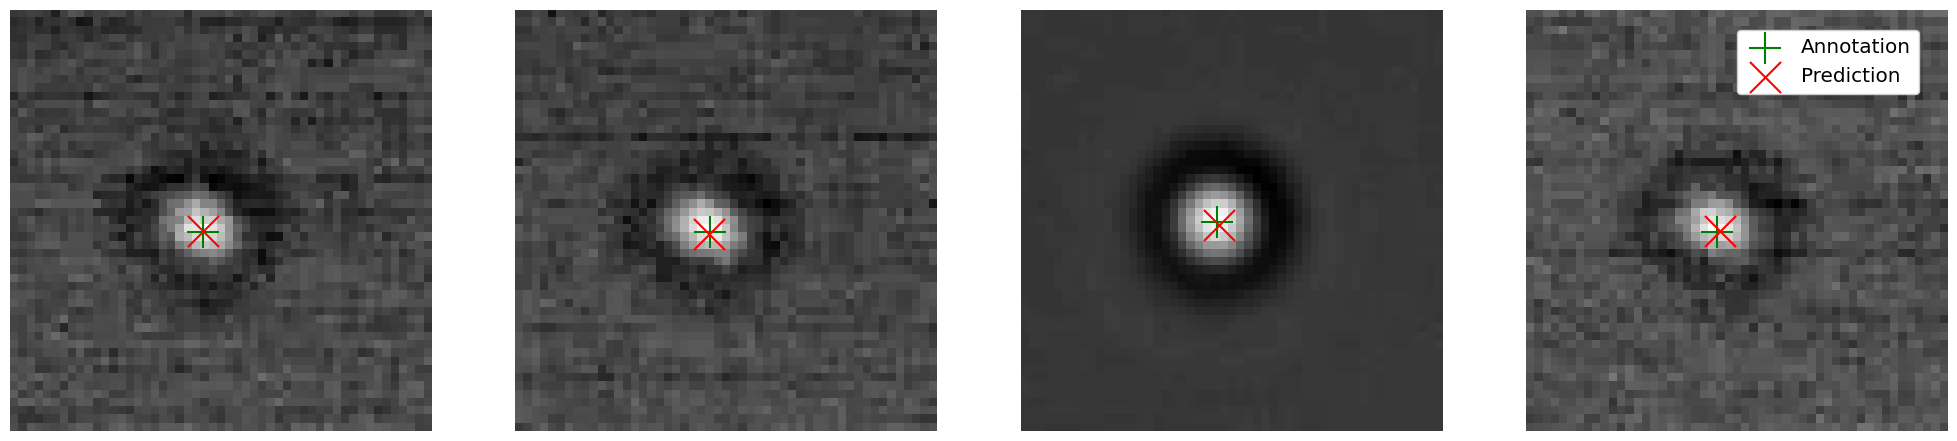

In [24]:
import torch

indices = np.random.choice(np.arange(len(test_ann_dataset)), 4, replace=False)
images = [test_ann_dataset[index][0] for index in indices]
annotations = [test_ann_dataset[index][1] for index in indices]
predictions = cnn_ann_regressor(torch.stack(images))

fig, axes = plt.subplots(1, 4, figsize=(25, 12))
for ax, im, ann, pred in zip(axes, images, annotations, predictions):
    ax.imshow(im.numpy().squeeze(), cmap="gray")
    
    ann = ann * image_size + image_size / 2
    ax.scatter(ann[0], ann[1], marker="+", c="g", s=500, label="Annotation")
    
    pred = pred.detach().numpy() * image_size + image_size / 2
    ax.scatter(pred[0], pred[1], marker="x", c="r", s=500, label="Prediction")
    
    ax.set_axis_off()
ax.legend(loc=(0.5, 0.8), framealpha=1, fontsize="x-large")
plt.show()

## Simulating the Training Data

Define the particle ...

In [31]:
from deeptrack.scatterers import MieSphere

particle = MieSphere(
    position=lambda: np.random.uniform(image_size / 2 - 5,
                                       image_size / 2 + 5, 2),
    z=lambda: np.random.uniform(-1, -1),
    radius=lambda: np.random.uniform(500, 600) * 1e-9,
    refractive_index=lambda: np.random.uniform(1.37, 1.42),
    position_unit="pixel",
)


... specify the optical device to image the particle ...

In [32]:
from deeptrack.optics import Brightfield

brightfield_microscope = Brightfield( 
    wavelength=630e-9,
    NA=0.8,
    resolution=1e-6,
    magnification=15,
    refractive_index_medium=1.33,
    output_region=(0, 0, image_size, image_size),
)

... combine them ...

In [33]:
imaged_particle = brightfield_microscope(particle)

... and plot them.

In [34]:
def plot_simulated_particles(image_pipeline):
    """Plot simulated particle."""
    fig, axes = plt.subplots(1, 4, figsize=(25, 12))
    for i, ax in enumerate(axes.flatten()):
        output_image = image_pipeline.update().resolve() 
        ax.imshow(np.squeeze(output_image), cmap="gray") 
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

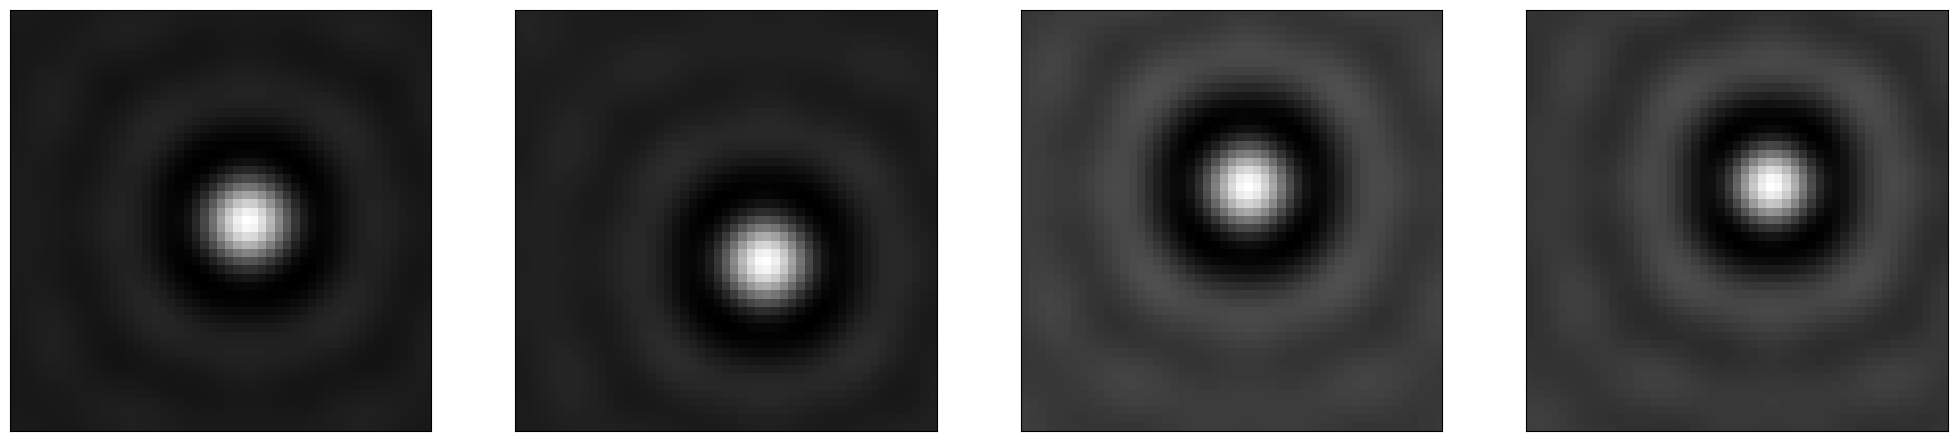

In [35]:
plot_simulated_particles(imaged_particle)

### Creating Images of Particles with Noise

Adding a Poisson noise source to the simulation pipeline ...

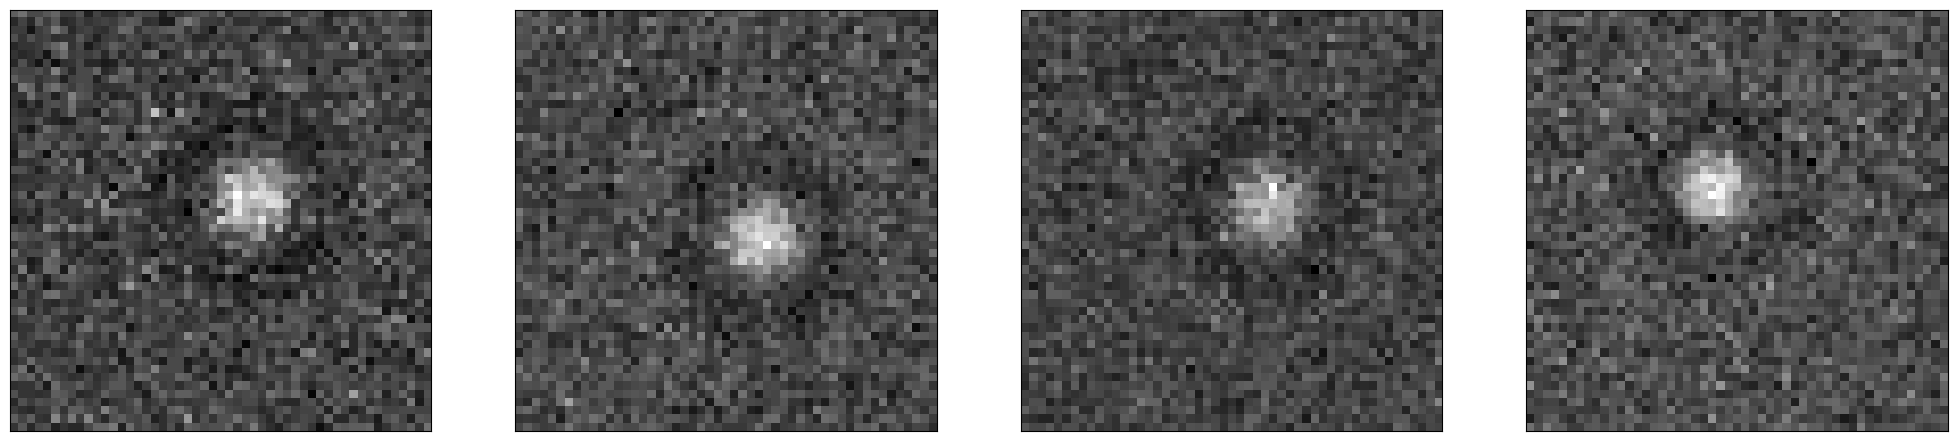

In [39]:
from deeptrack import Poisson

noise = Poisson(
    min_snr=5,
    max_snr=20,
    snr=lambda min_snr, max_snr: min_snr + np.random.rand() * (max_snr 
                                                               - min_snr),
    background=1, 
)
noisy_imaged_particle = imaged_particle >> noise

plot_simulated_particles(noisy_imaged_particle)

... and create a pipeline that generates noisy particle images and normalize the pixel values. 

In [40]:
from deeptrack import NormalizeMinMax

normalization = NormalizeMinMax(lambda: np.random.rand() * 0.2, 
                                lambda: 0.8 + np.random.rand() * 0.2)
image_pipeline = noisy_imaged_particle >> normalization

### Getting the Positions from the Simulated Images

Define a function to exctract the particle centroid position from the image ...

In [41]:
def get_label(image):
    """Get simulated particle position."""
    position = np.array(image.get_property("position"))
    return position

... use it to get the position of the simulated particle ...

In [42]:
output_image = image_pipeline.update().resolve()
particle_position = get_label(output_image)

... and plot them on top of the particle images.

In [47]:
def plot_simulated_particles_with_positions(image_pipeline):
    """Plot simulated particle with position."""
    fig, axes = plt.subplots(1, 4, figsize=(25, 12))
    for i, ax in enumerate(axes.flatten()):
        output_image = image_pipeline.update().resolve() 
        particle_position = get_label(output_image)
        
        ax.imshow(np.squeeze(output_image), cmap="gray")
        ax.scatter(particle_position[1], particle_position[0], s=60,
                   facecolors="none", edgecolor="g", linewidth=4)
        
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

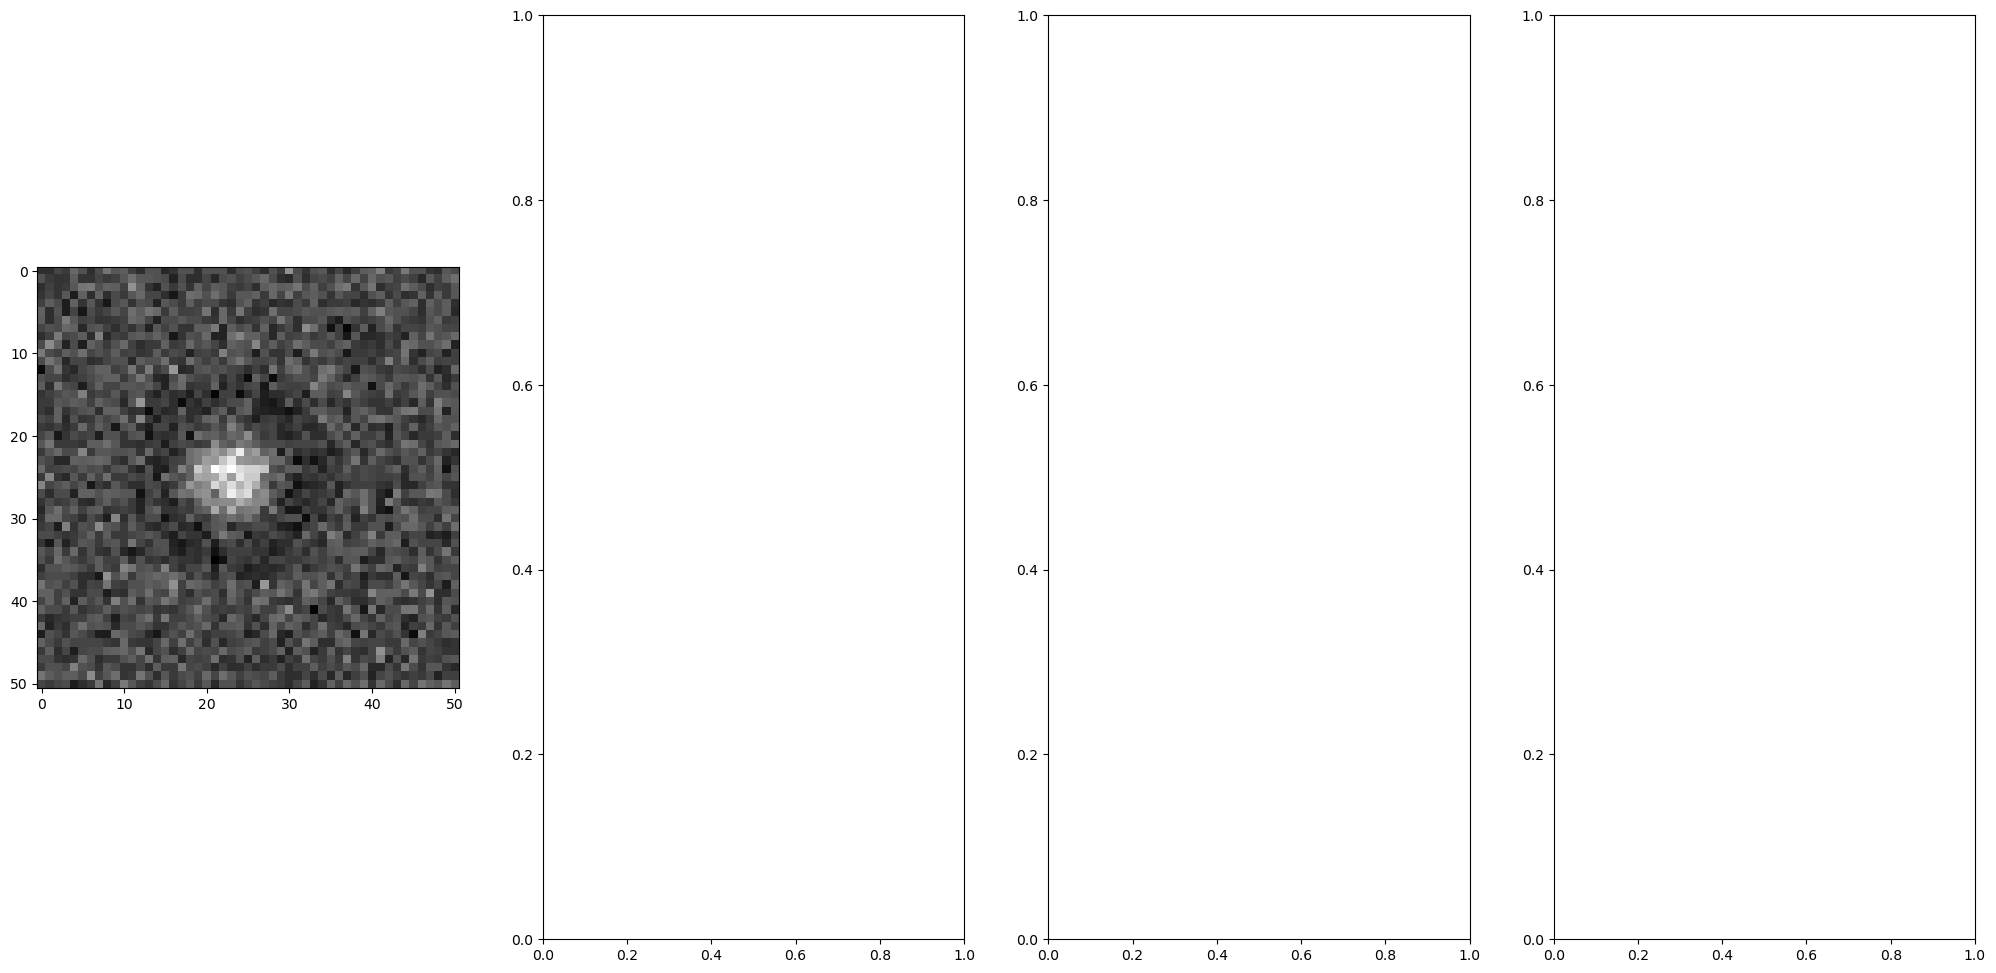

In [48]:
plot_simulated_particles_with_positions(image_pipeline)

## Train the Neural Network with Simulated Data

We want to use the simulations for the CNN training. Thus, we modify the class `AnnotatedDataset` to now work with the simulation pipeline, creating the new class `SimulatedDataset`
```python
class SimulatedDataset(Dataset):
    def __init__(self, pipeline, data_size):
        images = [pipeline.update().resolve() for _ in range(data_size)]
        self.images = np.array(images).squeeze()
        self.positions = np.array([get_label(im) for im in images])[:, [1, 0]]

    def __len__(self):
        return self.image.shape[0]

    def __getitem__(self, idx):
        im = torch.tensor(self.images[idx, np.newaxis, :, :]).float()
        pos = torch.tensor(self.positions[idx] / image.shape[-1] - 0.5).float()
        sample = [im, pos]
        return sample
```
The class can be used with the data loader and passed to the CNN for training.

In [ ]:
from fnc_particle_localization import SimulatedDataset

train_sim_dataloader = dl.DataLoader(
    SimulatedDataset(pipeline=image_pipeline, data_size=10000), batch_size=32
)

cnn_sim_regressor = regressor_template.create()
cnn_sim_trainer = dl.Trainer(max_epochs=50, accelerator="auto")
cnn_sim_trainer.fit(cnn_sim_regressor, train_sim_dataloader)

We check the network performance on a simulated test dataset...

In [ ]:
test_sim_dataloader = dl.DataLoader(
    SimulatedDataset(pipeline=image_pipeline, data_size=100), batch_size=32
)

test_sim_results = cnn_sim_trainer.test(cnn_sim_regressor, test_sim_dataloader)

MAE_sim = test_sim_results[0]["testMeanAbsoluteError_epoch"] * image_size
print(f"Mean pixel error (MAE): {MAE_sim:.3f} pixels")

... and plot the predictions versus the ground truth.

In [ ]:
pred, gt = [], []
for batch in iter(test_sim_dataloader):
    pred.append(cnn_sim_regressor(batch[0]))
    gt.append(batch[1])
pred = torch.cat(pred, dim=0).detach().numpy()
gt = torch.cat(gt, dim=0).numpy()

fig, axs = plt.subplots(1, 2)
for i, ax, coordinate in zip([0, 1], axs, ["x", "y"]):
    label = gt[:][:, i]
    prediction = pred[:][:, i]
    ax.scatter(label, prediction, alpha=0.2)
    ax.plot([np.min(label), np.max(label)], [np.min(label), np.max(label)], c="k")
    ax.set_title(f"{coordinate}-coordinates")
    ax.set_xlabel("Prediction"), ax.set_ylabel("Ground truth")
    ax.set_aspect("equal"), ax.set_xlim([-.07, .07]), ax.set_ylim([-.07, .07])
    ax.label_outer()

plt.show()

Let's check now the CNN predictions on the annotated test dataset.

In [ ]:
test_ann_results_with_cnn_sim = cnn_sim_trainer.test(cnn_sim_regressor, 
                                                     test_ann_dataloader)

MAE_ann_with_cnn_sim = (test_ann_results_with_cnn_sim[0]
                        ["testMeanAbsoluteError_epoch"] * image_size)
print(f"Mean pixel error (MAE): {MAE_ann_with_cnn_sim:.3f} pixels")

Last, we plot the predictions in comparison to the annotations.

In [ ]:
images = [test_ann_dataset[index][0] for index in indices]
annotations = [test_ann_dataset[index][1] for index in indices]
predictions = cnn_sim_regressor(torch.stack(images))

fig, axes = plt.subplots(1, 4, figsize=(25, 12))
for ax, im, ann, pred in zip(axes, images, annotations, predictions):
    ax.imshow(im.numpy().squeeze(), cmap="gray")
    
    ann = ann * image_size + image_size / 2
    ax.scatter(ann[0], ann[1], marker="+", c="g", s=500, label="Annotation")
    
    pred = pred.detach().numpy() * image_size + image_size / 2
    ax.scatter(pred[0], pred[1], marker="x", c="r", s=500, label="Prediction")

    ax.set_axis_off()

ax.legend(loc=(0.5, 0.8), framealpha=1, fontsize='x-large')
plt.show()
